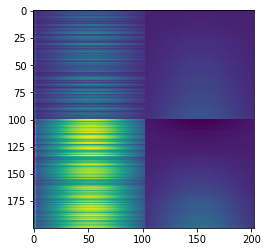

In [295]:

# Generate synthetic datasets

import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy
from scipy import signal

N_PER_GROUP = 100
SIZE_SIGNAL = 100
SIZE_CONF = 100


df_conf = pd.DataFrame(zip(
    np.concatenate((
        np.zeros(N_PER_GROUP),
        np.ones(N_PER_GROUP),)
        ),
    np.concatenate((
        np.random.uniform(0, 2, size=N_PER_GROUP),
        np.random.uniform(-1, 3, size=N_PER_GROUP))
        ),
    np.concatenate((
        np.random.uniform(1, 4, size=N_PER_GROUP),
        np.random.uniform(5, 10, size=N_PER_GROUP))
        ),
), columns=['label', 'confounder','signal'])

def gkern(kernlen=16, std=5, dim=2):
    
    """Returns a Gaussian kernel array."""
    
    kern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    if dim == 2:
        kernel_raw = numpy.outer(kern1d, kern1d)
    else:
        kernel_raw = kern1d
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def gen_feature(signal, conf, shape=(20, 20, 1), std=30):
    sig = gkern(shape[0], std, shape[2]) * signal * shape[0]
    conf = gkern(shape[1], std, shape[2]) * conf * shape[1]
    feat = np.concatenate((sig, conf))
    if shape[1] == 1:
        return feat.flatten()
    else:
        return feat


cm = sns.light_palette("green", as_cmap=True)
df_conf['feature'] = df_conf.apply(lambda x: gen_feature(x['signal'], x['confounder'], shape=(SIZE_SIGNAL, SIZE_CONF, 1)), axis=1)
df_conf = df_conf.explode("feature")
df_conf['feat_name'] = list(range(SIZE_SIGNAL+SIZE_CONF)) * (N_PER_GROUP*2)

df_conf = df_conf.pivot(index=['label','confounder','signal'], columns='feat_name', values='feature').reset_index().astype(float)

df_conf.columns.name = None
#print(df_conf.groupby("label").describe())

plt.imshow(df_conf.values)